In [14]:
import pandas as pd
import numpy as np
import nltk 
import sklearn 
import tarfile


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('reuters')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt
import seaborn as sns
import re


with open('dem debate transcript 1.1.txt', 'rb') as f1: 
  text1 = f1.read()
  
with open('dem debate transcript 1.2.2.txt', 'rb') as f2: 
  text2 = f2.read()    

with open('dem debate transcript 2.1.txt', 'rb') as f3:
  text3 = f3.read()
  
with open('dem debate transcript 2.2.txt', 'rb') as f4:
  text4 = f4.read()
  
with open('dem debate transcript 3.txt', 'rb') as f5:
  text5 = f5.read()
  
sentiment_df = pd.read_excel('labeled sentiment list.xlsx')
zipobj = zip(sentiment_df['WORD'], sentiment_df['VALUE'])
sentiment_dict = dict(zipobj)

names_list1_1 = ['HOLT', 'GUTHRIE', 'WARREN', 'O ROURKE', 'BOOKER', 'KLOBUCHAR', 
              'CASTRO', 'GABBARD', 'DIAZ BALART', 'DE BLASIO', 'DELANEY', 'RYAN',
             'INSLEE', 'TODD', 'MADDOW', 'UNKNOWN']

candidate_list1_1 = ['WARREN', 'O ROURKE', 'BOOKER', 'KLOBUCHAR', 
              'CASTRO', 'GABBARD', 'DE BLASIO', 'DELANEY', 'RYAN',
             'INSLEE']

names_list1_2 = ['HOLT', 'GUTHRIE', 'MADDOW', 'TODD', 'SANDERS', 'GILLIBRAND', 'BOOKER', 
               'BENNET', 'BIDEN', 'HARRIS', 'HICKENLOOPER, BUTTIGIEG', 'DIAZ BALART',  'YANG',
              'SWALWELL', 'DE BLASIO', 'WILLIAMSON', 'UNKNOWN']

candidate_list1_2 = ['SANDERS', 'GILLIBRAND', 'BENNET', 'BIDEN', 'HARRIS', 'HICKENLOOPER', 'BUTTIGIEG', 'YANG',
              'SWALWELL', 'WILLIAMSON']

names_list2_1 = ['TAPPER', 'BASH', 'LEMON', 'SANDERS', 'WARREN', 'BUTTIGIEG', 'O ROURKE', 'KLOBUCHAR', 'HICKENLOOPER',
                'RYAN', 'DELANEY', 'WILLIAMSON', 'BULLOCK']

candidate_list2_1 = ['SANDERS', 'WARREN', 'BUTTIGIEG', 'O ROURKE', 'KLOBUCHAR', 'HICKENLOOPER',
                'RYAN', 'DELANEY', 'WILLIAMSON', 'BULLOCK']

names_list2_2 = ['TAPPER', 'BASH', 'LEMON', 'BIDEN', 'HARRIS', 'BOOKER', 'CASTRO', 'YANG', 'GABBARD', 'GILLIBRAND',
                'INSLEE', 'BENNET', 'DE BLASIO'] 

candidate_list2_2 = ['BIDEN', 'HARRIS', 'BOOKER', 'CASTRO', 'YANG', 'GABBARD', 'GILLIBRAND',
                'INSLEE', 'BENNET', 'DE BLASIO']

names_list3 = ['MUIR', 'DAVIS', 'RAMOS', 'BIDEN', 'WARREN', 'BOOKER', 'SANDERS', 'HARRIS', 'BUTTIGIEG',
              'CASTRO', 'KLOBUCHAR', 'O ROURKE', 'YANG']

candidate_list3 = ['BIDEN', 'WARREN', 'BOOKER', 'SANDERS', 'HARRIS', 'BUTTIGIEG',
              'CASTRO', 'KLOBUCHAR', 'O ROURKE', 'YANG']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


1. Clean debate transcripts [x]
2. Put debate transcripts into df [x]
3. Group df by speaker [x]
4. Collect sentiment-opinion word list [x]
5. Put sentiment-opinion word list into dictionary [x]
6. Map sentiment-opinion dictionary for each speaker into df [x]
7. Assign sentiment-opinion value, per line, per speaker:

  a) if negate word ('not', 'none', etc.), value = -1*value []
  
  b) polarity = (pos-neg)/(pos+neg) []
  
  c) subjectivity = (pos+neg)/count(*) []

8. Find average sentiment per speaker, per speaker to group, group as whole, etc. []
9. NLP analysis per speaker group : 
  a) most frequent words used [x]
  b) WORDCLOUD for speaker []





In [0]:
### Functions library

def deep_flatten(xs): 
  '''
  Flattens a deeplist into a list of its base elements
      
  Args: xs = deeplist  
  '''
  
  flat_list = []
  [flat_list.extend(deep_flatten(x)) for x in xs] if isinstance(xs, list) else flat_list.append(xs)
  return flat_list
  
def split_text(text):
  '''
  Splits text by designated mark (:)
     
  Args: text = text to split 
  '''
  count = 0
  text_list = []
  for line in text.copy():
    line = line.split(':')
    text_list.append(line)
    count += 1
  
  return text_list

def split_lines(df):   
  '''
  Tokenizes speaker lines and adds-in new column to the df
  
  Args: df = DataFrame to target  
  '''
  
  line_list = []
  
  for line in df['line']:
    split_line = word_tokenize(str(line))
    split_line = [word for word in split_line if word.isalpha() is True]
    split_line = [word for word in split_line if word not in stopwords.words('english')]
    split_line = [word.lower() for word in split_line]
    line_list.append(split_line) 
    
  return line_list 
  
  
def map_sentiment_value(df):
  count = 0
  val_list = []
  for line in line_list:
    value_map = list(map(sentiment_dict.get, line_list[count]))
    sentiment_val = [val for val in value_map if val != None]
    val_list.append(sentiment_val) 
    count += 1
    
  df['sentiment value'] = val_list 
  
def freq_bar_plot(freq_dist, name): 
  ''' Plots word frequencies from FreqDist operator'''

  fig = plt.figure(figsize=(8,6))
  plt.bar([value[0] for value in freq_dist], [value[1] for value in freq_dist], width=.5, color='royalblue', )
  plt.xticks(rotation=60)
  plt.xlabel('Word')
  plt.ylabel('Frequency')
  plt.title(name)
  plt.show()
  
def find_plot_frequencies(df, names_list):
  for name in names_list: 
    words_list = []
    for line in df.get_group(name)['split line']:
      word = [word for word in line]
      words_list.append(word) 
      words_list = deep_flatten(words_list)
      for word in words_list:
        if word in stopwords.words('english'):
          words_list.remove(word)

      freq_dist = FreqDist(words_list).most_common(20)
      words_set = set(words_list)

    print(name, freq_dist) 
    freq_bar_plot(freq_dist, name) 
    print(name, ':', len(words_set), ':', words_set)
  
def convert_tag(tag):
    '''
    Convert the tag given by nltk.pos_tag to the tag used by wordnet.synsets
    '''
    
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        return None
      
def get_synsets(line):
  tokens = word_tokenize(line)
  pos_tags = pos_tag(tokens) 
  tag_list = [tag[1] for tag in pos_tags]
  wordnet_tags = [convert_tag(tag) for tag in tag_list]
  synset_taglist = zip(tokens, wordnet_tags)
  all_synsets = [wn.synsets(x,y) for x,y in synset_taglist]
  top_synset = [val[0] for val in all_synsets if len(val) > 0] 

  return top_synset


def similarity_score(s1, s2):
    """
    Calculate the normalized similarity score of s1 onto s2

    For each synset in s1, finds the synset in s2 with the largest similarity value.
    Sum of all of the largest similarity values and normalize this value by dividing it by the
    number of largest similarity values found.

    Args:
        s1, s2: list of synsets from doc_to_synsets

    Returns:
        normalized similarity score of s1 onto s2

    Example:
        synsets1 = doc_to_synsets('I like cats')
        synsets2 = doc_to_synsets('I like dogs')
        similarity_score(synsets1, synsets2)
        Out: 0.73333333333333339
    """
    
    syn_scores =[]
    for syn1 in s1:
        score_list = []
        for syn2 in s2:
            score_list.append(syn1.path_similarity(syn2))
        score = [x for x in score_list if x is not None]
        if len(score) > 0 :
            syn_scores.append(max(score))

    return sum(syn_scores)/len(syn_scores)


def document_path_similarity(doc1, doc2):
    """Finds the symmetrical similarity between doc1 and doc2"""

    synsets1 = get_synsets(doc1)
    synsets2 = get_synsets(doc2)

    return (similarity_score(synsets1, synsets2) + similarity_score(synsets2, synsets1)) / 2
  



In [0]:
### Clean-up the 1st .txt file (Debate 1 Round 1)

text1 = text1.replace(b'\x92', b' ')
text1 = text1.replace(b'\x97', b' ')
text1 = text1.replace(b'\x91', b' ')
text1 = text1.replace(b'DEBLASIO', b'DE BLASIO')
text1 = text1.replace(b'DIAZ-BALART', b'DIAZ BALART')
text1 = text1.decode('utf-8')
text1 = text1.split('\r\n\r\n')



In [0]:
### Clean-up the 2nd .txt file (Debate 1 Round 2)
text2 = text2.replace(b'\x92', b' ')
text2 = text2.replace(b'\x93', b' ')
text2 = text2.replace(b'\x94', b' ')
text2 = text2.replace(b'\x97', b' ')

text2 = text2.decode('utf-8')
text2 = text2.split('\r\n\r\n')


In [0]:
###Clean-up the 3rd .txt file (Debate 2 Round 1)

text3 = text3.replace(b'\x92', b' ')
text3 = text3.replace(b'\x93', b' ')
text3 = text3.replace(b'\x94', b' ')
text3 = text3.replace(b'\x97', b' ')
text3 = text3.replace(b"O'ROURKE", b'O ROURKE')

text3 = text3.decode('utf-8')
text3 = text3.split('\r\n\r\n')

In [0]:
### Clean-up the 4th .txt file (Debate 2 Round 2)

text4 = text4.replace(b'\x92', b' ')
text4 = text4.replace(b'\x93', b' ')
text4 = text4.replace(b'\x94', b' ')
text4 = text4.replace(b'\x97', b' ')

text4 = text4.decode('utf-8')
text4 = text4.split('\r\n\r\n')

In [0]:
text5 = text5.replace(b'\x92', b' ')
text5 = text5.replace(b'\x93', b' ')
text5 = text5.replace(b'\x94', b' ')
text5 = text5.replace(b'\x97', b' ')

text5 = text5.decode('utf-8')
text5 = text5.split('\r\n\r\n')

In [0]:
text5

In [0]:
### Split text into speaker and corresponding line

text_list1 = split_text(text1)
text_list2 = split_text(text2)
text_list3 = split_text(text3)
text_list4 = split_text(text4) 
text_list5 = split_text(text5)

In [0]:
### Build DataFrames by speaker, line, and add-in tokenized line

text_df1 = pd.DataFrame(text_list1).rename(columns={0:'speaker', 1:'line'}).drop(columns=2).dropna(how='any', axis=0) #Debate 1 Round 1
text_df1['split line'] = [line for line in split_lines(text_df1)]

text_df2 = pd.DataFrame(text_list2).rename(columns={0:'speaker', 1:'line'}).drop(columns=2).dropna(how='any', axis=0) #Debate 1 Round 2
text_df2['split line'] = [line for line in split_lines(text_df2)]

text_df3 = pd.DataFrame(text_list3).rename(columns={0:'speaker', 1:'line'}).drop(columns=2).dropna(axis=0) #Debate 2 Round 1
text_df3['split line'] = [line for line in split_lines(text_df3)]

text_df4 = pd.DataFrame(text_list4).rename(columns={0:'speaker', 1:'line'}).drop(columns=[2,3]) #Debate 2 Round 2
text_df4['split line'] = [line for line in split_lines(text_df4)]

text_df5 = pd.DataFrame(text_list5).rename(columns={0:'speaker', 1:'line'}).drop(columns=[2,3]) #Debate 3
text_df5['split line'] = [line for line in split_lines(text_df5)]


In [28]:
text_df5.head()

,speaker,line,split line
0,STEPHANOPOULOS,"Good evening, and welcome to Houston. We are ...","[good, evening, welcome, houston, we, live, te..."
1,RAMOS,"George, thank you very much. We appreciate th...","[george, thank, much, we, appreciate, opportun..."
2,DAVIS,We are delighted to be on the beautiful campu...,"[we, delighted, beautiful, campus, texas, sout..."
3,MUIR,"We can feel the energy in the room, can't we,...","[we, feel, energy, room, ca, linsey, the, rule..."
4,STEPHANOPOULOS,The podium placement was based on their curre...,"[the, podium, placement, based, current, stand..."


In [0]:
### Map sentiment value onto tokens in df1:

count = 0
val_list = []
for line in line_list:
  value_map = list(map(sentiment_dict.get, line_list[count]))
  sentiment_val = [val for val in value_map if val != None]
  val_list.append(sentiment_val)
  count = count +1
  
text_df['sentiment value'] = val_list


### Map sentiment value onto tokens in df2: 

count = 0
val_list = []
for line in line_list2:
  value_map = list(map(sentiment_dict.get, line_list2[count]))
  sentiment_val = [val for val in value_map if val != None]
  val_list.append(sentiment_val)
  count = count +1

text_df2['sentiment value'] = val_list

In [0]:
### Sum per-sentence sentiment values in df1
sum_list = []
for value in text_df['sentiment value']:
  val_sum = sum(value)
  sum_list.append(val_sum)

text_df['sum value'] = [val_sum for val_sum in sum_list]

### Assign sentiment tag (-1, 0, 1) to each line in df1
val_list = []
for value in text_df['sum value']:
  if value > 0:
    val_list.append(1)
  if value < 0:
    val_list.append(-1)
  if value == 0:
    val_list.append(0)
    
text_df['sentiment'] = [val for val in val_list]


### Sum per-sentence sentiment values in df2
sum_list = []
for value in text_df2['sentiment value']:
  val_sum = sum(value)
  sum_list.append(val_sum)
  
text_df2['sum value'] = [val_sum for val_sum in sum_list]

### Assign sentiment tag (-1, 0, 1) to each line in df2
val_list = []
for value in text_df2['sum value']:
  if value > 0:
    val_list.append(1)
  if value < 0:
    val_list.append(-1)
  if value == 0:
    val_list.append(0)
    
text_df2['sentiment'] = [val for val in val_list]


In [0]:
### Copied df grouped by speaker 

text_df_copy1 = text_df1.copy()
grouped_df1 = text_df_copy1.groupby('speaker')

text_df_copy2 = text_df2.copy()
grouped_df2 = text_df_copy2.groupby('speaker')

text_df_copy3 = text_df3.copy()
grouped_df3 = text_df_copy3.groupby('speaker')

text_df_copy4 = text_df4.copy()
grouped_df4 = text_df_copy4.groupby('speaker') 

text_df_copy5 = text_df5.copy()
grouped_df5 = text_df_copy5.groupby('speaker') 

In [30]:
grouped_df5.groups

{'ANNOUNCER': Int64Index([202], dtype='int64'),
 'BIDEN': Int64Index([ 23,  25,  35,  37,  43,  53,  63,  65,  67,  72,  75,  78,  80,
              82,  84,  86,  88, 115, 117, 123, 125, 126, 135, 138, 141, 159,
             167, 169, 171, 173, 180, 182, 185, 222, 225, 234, 237, 287, 289,
             304, 306, 308],
            dtype='int64'),
 'BOOKER': Int64Index([11, 100, 107, 119, 156, 158, 224, 226, 251, 297, 299, 301, 321], dtype='int64'),
 'BUTTIGIEG': Int64Index([15, 57, 91, 93, 109, 195, 197, 206, 208, 233, 268, 317], dtype='int64'),
 "But that means we've got to use all the tools. One of the tools we need to use are our regulatory tools. I have proposed following Governor Inslee, that we, by 2028, cut all carbon emissions from new buildings. By 2030, carbon emissions from cars. And by 2035, all carbon emissions from the manufacture of electricity. That alone, those three, will cut our emissions here in the United States by 70 percent. We can do this. We also need to help ar

In [0]:
###Count top-20 words by frequency and plot for each candidate in each round (1-4); 
###Find the total number of unique words spoken by the candidadate

find_plot_frequencies(grouped_df, candidate_list1_1)
find_plot_frequencies(grouped_df2, candidate_list1_2)
find_plot_frequencies(grouped_df3, candidate_list2_1)
find_plot_frequencies(grouped_df4, candidate_list2_2)

SANDERS [('people', 19), ('going', 17), ('got', 12), ('america', 11), ('health', 10), ('industry', 10), ('right', 9), ('companies', 9), ('american', 9), ('system', 9), ('insurance', 9), ('care', 8), ('percent', 8), ('new', 8), ('want', 8), ('country', 8), ('one', 7), ('take', 7), ('trump', 7), ('medicare', 7)]


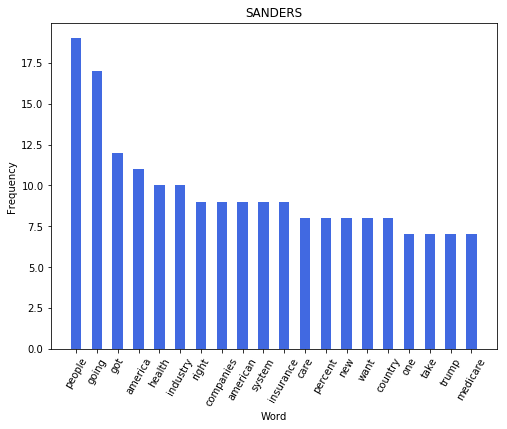

SANDERS : 611 : {'us', 'back', 'get', 'humane', 'supportive', 'like', 'policy', 'honduras', 'incredible', 'human', 'win', 'mentioned', 'universities', 'end', 'fuel', 'finally', 'bring', 'make', 'helped', 'lobbying', 'transition', 'billion', 'pntr', 'phony', 'dangerous', 'save', 'wealth', 'financial', 'earth', 'easy', 'simple', 'gangs', 'millions', 'problems', 'care', 'bankrupt', 'fact', 'campaign', 'assault', 'institutional', 'inequality', 'coming', 'taxes', 'dog', 'differences', 'budget', 'mother', 'start', 'exactly', 'little', 'focus', 'income', 'medicare', 'fortune', 'citizens', 'border', 'president', 'view', 'week', 'legislation', 'vote', 'loophole', 'strong', 'guatemala', 'owns', 'anniversary', 'education', 'wall', 'federal', 'hearing', 'beating', 'see', 'many', 'understands', 'accept', 'disastrous', 'choice', 'criminals', 'virtually', 'terms', 'destroy', 'give', 'donald', 'know', 'reform', 'modern', 'doctor', 'applies', 'said', 'average', 'contracts', 'billions', 'tell', 'go', 't

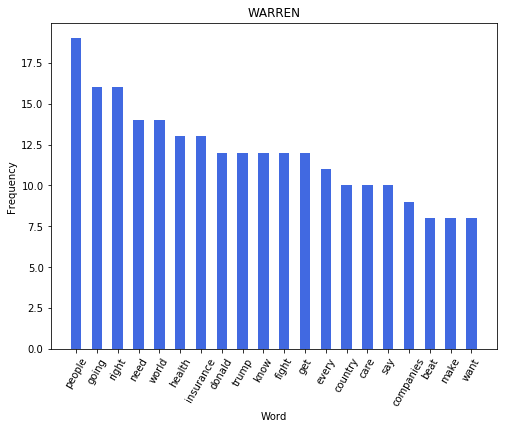

WARREN : 566 : {'us', 'back', 'get', 'pitch', 'like', 'policy', 'throat', 'human', 'win', 'mentioned', 'universities', 'end', 'able', 'make', 'helped', 'billion', 'save', 'wealth', 'apart', 'criminalize', 'earth', 'native', 'might', 'problems', 'care', 'used', 'fact', 'unions', 'farmers', 'armies', 'forms', 'washington', 'online', 'long', 'budget', 'longer', 'mother', 'start', 'popular', 'build', 'little', 'bet', 'medicare', 'border', 'president', 'vote', 'track', 'hands', 'dream', 'begging', 'month', 'wall', 'feature', 'visas', 'stake', 'rest', 'market', 'disgraces', 'stop', 'black', 'see', 'many', 'iran', 'weapon', 'regulatory', 'given', 'cover', 'terms', 'game', 'preemptively', 'give', 'puts', 'candidate', 'donald', 'boy', 'know', 'named', 'doctor', 'elected', 'negotiated', 'said', 'billions', 'tell', 'go', 'doctors', 'loyalty', 'best', 'raise', 'products', 'companies', 'fight', 'would', 'much', 'promise', 'path', 'right', 'lot', 'kicked', 'sucked', 'create', 'environment', 'remembe

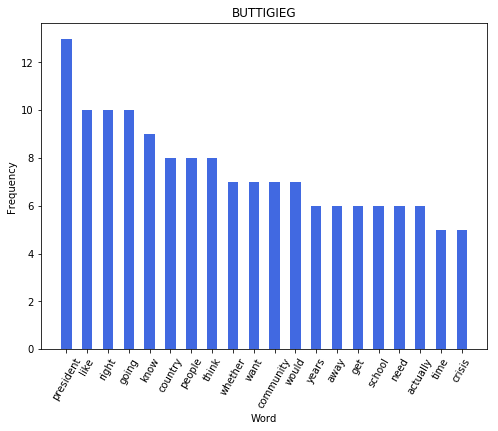

BUTTIGIEG : 659 : {'policies', 'us', 'back', 'get', 'south', 'like', 'policy', 'ads', 'stepping', 'allow', 'win', 'end', 'scripture', 'able', 'make', 'shaking', 'involved', 'factories', 'apply', 'consoling', 'save', 'dominated', 'voices', 'wealth', 'held', 'might', 'care', 'fact', 'became', 'speculating', 'assault', 'directed', 'options', 'stain', 'since', 'tech', 'taxes', 'washington', 'incompetence', 'long', 'almost', 'endless', 'wondering', 'argue', 'start', 'exactly', 'build', 'constitution', 'veteran', 'medicare', 'citizens', 'border', 'president', 'view', 'week', 'vote', 'hands', 'routine', 'lucky', 'remembered', 'career', 'education', 'month', 'leading', 'buy', 'event', 'stop', 'black', 'likely', 'see', 'many', 'worth', 'whatever', 'voters', 'propose', 'whoever', 'leaders', 'houses', 'talked', 'switch', 'gig', 'presidency', 'hit', 'donald', 'know', 'reform', 'growing', 'accountable', 'average', 'go', 'accountability', 'today', 'third', 'hurting', 'amounts', 'raise', 'best', 'exp

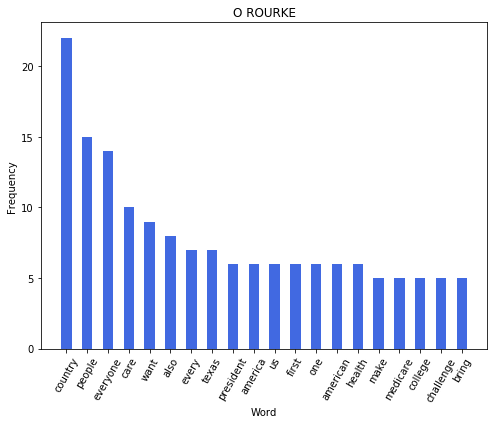

O ROURKE : 556 : {'us', 'back', 'get', 'like', 'human', 'win', 'tradition', 'end', 'bring', 'able', 'reparations', 'make', 'success', 'literally', 'wealth', 'apart', 'mexican', 'abroad', 'millions', 'care', 'became', 'unions', 'pursue', 'farmers', 'winning', 'taxes', 'sensibilities', 'immigrants', 'successfully', 'holders', 'educated', 'forever', 'differences', 'almost', 'long', 'endless', 'executive', 'waited', 'muslim', 'focus', 'medicare', 'week', 'president', 'democrat', 'denied', 'margins', 'labor', 'education', 'improve', 'crow', 'challenge', 'rest', 'starting', 'diversity', 'federal', 'january', 'associate', 'many', 'whatever', 'future', 'choice', 'criminals', 'wind', 'cover', 'waived', 'candidate', 'donald', 'woman', 'yemen', 'know', 'reform', 'somalia', 'accountable', 'alike', 'said', 'today', 'third', 'term', 'explain', 'still', 'nothing', 'board', 'path', 'governor', 'promise', 'would', 'influence', 'right', 'sure', 'segregation', 'create', 'environment', 'city', 'allies', '

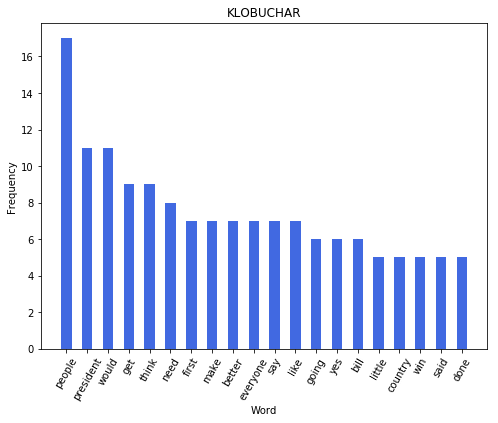

KLOBUCHAR : 452 : {'us', 'back', 'get', 'like', 'policy', 'allow', 'win', 'bring', 'make', 'integrity', 'fault', 'literally', 'daughter', 'dad', 'casey', 'chalmers', 'birmingham', 'simple', 'shared', 'care', 'assault', 'meeting', 'immigrants', 'tv', 'clearly', 'watched', 'programs', 'little', 'african', 'border', 'president', 'turnout', 'hurt', 'butter', 'vote', 'loophole', 'bottled', 'repayment', 'democrat', 'triangle', 'education', 'wall', 'improve', 'monroe', 'simply', 'buy', 'voter', 'rest', 'bringing', 'stop', 'see', 'iran', 'weapon', 'eight', 'champion', 'give', 'sick', 'candidate', 'donald', 'woman', 'boy', 'know', 'expensive', 'elected', 'said', 'putin', 'tell', 'today', 'go', 'doctors', 'miner', 'still', 'nothing', 'companies', 'would', 'path', 'governor', 'traffic', 'right', 'lot', 'obey', 'sure', 'parts', 'mama', 'remember', 'city', 'invading', 'ok', 'world', 'leader', 'romero', 'easiest', 'wealthy', 'climate', 'flint', 'prescription', 'asylum', 'tax', 'childcare', 'race', '

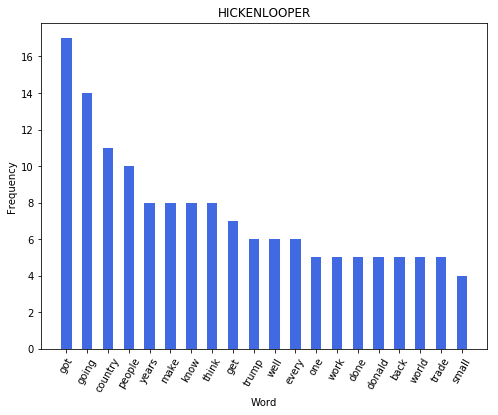

HICKENLOOPER : 447 : {'policies', 'us', 'back', 'get', 'directly', 'like', 'glory', 'allow', 'incredible', 'win', 'pub', 'able', 'success', 'make', 'fund', 'delaney', 'governors', 'fixable', 'ballot', 'might', 'problems', 'care', 'used', 'became', 'farmers', 'convincing', 'washington', 'onto', 'hangers', 'implemented', 'build', 'little', 'due', 'focus', 'spring', 'medicare', 'expanded', 'track', 'hands', 'fairly', 'seem', 'losers', 'nonsense', 'purple', 'fought', 'seats', 'see', 'many', 'fundamental', 'whatever', 'future', 'voters', 'template', 'talked', 'per', 'progressive', 'give', 'magazine', 'colorado', 'donald', 'woman', 'know', 'soybean', 'reform', 'doctor', 'engagement', 'go', 'recognition', 'doctors', 'best', 'still', 'much', 'governor', 'promise', 'would', 'recognize', 'right', 'sure', 'city', 'world', 'theater', 'cheating', 'climate', 'wars', 'tax', 'kicking', 'return', 'went', 'afghanistan', 'country', 'tomorrow', 'distraction', 'law', 'actually', 'well', 'anything', 'frustr

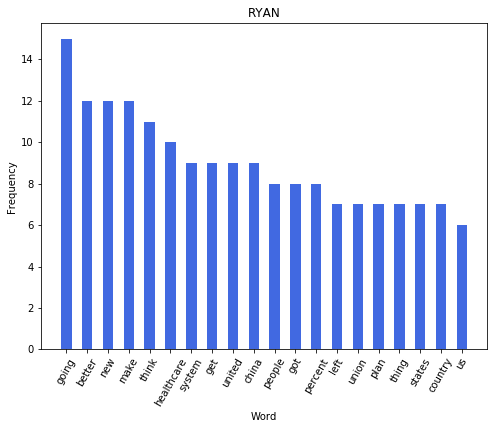

RYAN : 440 : {'effective', 'us', 'get', 'directly', 'like', 'policy', 'allow', 'win', 'report', 'fuel', 'able', 'success', 'make', 'soil', 'goods', 'photo', 'amy', 'factories', 'apply', 'food', 'gasoline', 'wealth', 'gave', 'financial', 'demilitarize', 'eroded', 'prevention', 'cars', 'care', 'used', 'weeks', 'farmers', 'quite', 'winning', 'tech', 'coming', 'global', 'washington', 'meeting', 'technologies', 'onto', 'long', 'tv', 'budget', 'deserve', 'start', 'build', 'focus', 'medicare', 'suffocating', 'border', 'president', 'targeted', 'strong', 'guatemala', 'education', 'buy', 'market', 'see', 'many', 'future', 'hillary', 'talked', 'regenerative', 'give', 'dominates', 'donald', 'know', 'clean', 'reforming', 'said', 'contracts', 'tell', 'go', 'today', 'investors', 'raise', 'explain', 'still', 'board', 'companies', 'would', 'much', 'dictators', 'right', 'sure', 'create', 'diplomacy', 'wages', 'past', 'shower', 'world', 'leader', 'camera', 'climate', 'asylum', 'subsidies', 'frankly', 'le

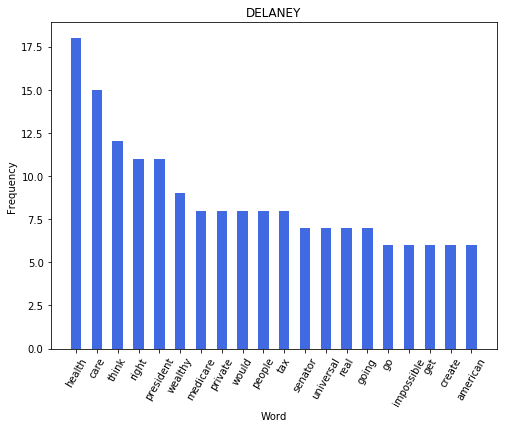

DELANEY : 449 : {'policies', 'us', 'back', 'forced', 'get', 'unrelated', 'like', 'policy', 'allow', 'folks', 'human', 'win', 'able', 'make', 'wealth', 'dad', 'simple', 'problems', 'care', 'data', 'became', 'roll', 'options', 'taxes', 'immigrants', 'forever', 'budget', 'start', 'creating', 'build', 'due', 'focus', 'income', 'medicare', 'bet', 'solving', 'president', 'arguably', 'loophole', 'mondale', 'dream', 'labor', 'grandkids', 'education', 'inaudible', 'entirely', 'buy', 'market', 'starting', 'fought', 'tale', 'many', 'worth', 'future', 'platform', 'voters', 'choice', 'species', 'code', 'cover', 'bettercare', 'give', 'donald', 'know', 'encourage', 'said', 'go', 'today', 'air', 'net', 'raise', 'companies', 'fight', 'would', 'promise', 'right', 'largely', 'create', 'city', 'allies', 'hospitals', 'dead', 'world', 'leader', 'financially', 'wealthy', 'investment', 'underfund', 'climate', 'tax', 'providers', 'divisiveness', 'congress', 'machines', 'country', 'transform', 'taken', 'standar

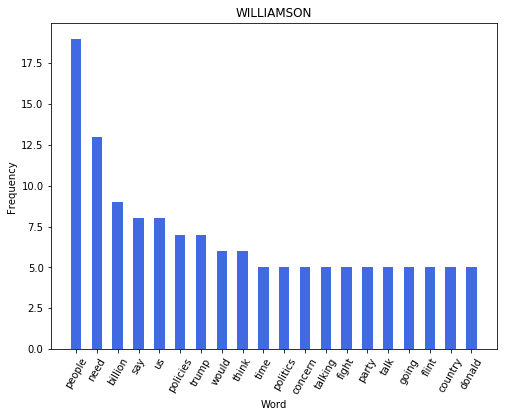

WILLIAMSON : 405 : {'policies', 'us', 'back', 'mistakes', 'get', 'recently', 'south', 'like', 'policy', 'win', 'end', 'conventional', 'fuel', 'bring', 'able', 'reparations', 'make', 'particularly', 'billion', 'food', 'voices', 'financial', 'might', 'care', 'fact', 'overlords', 'almost', 'risen', 'dog', 'start', 'president', 'legislation', 'vote', 'surface', 'toxicity', 'turbulence', 'leading', 'seem', 'simply', 'totally', 'federal', 'bringing', 'trillions', 'donors', 'see', 'many', 'future', 'politically', 'given', 'game', 'sick', 'philosophy', 'donald', 'hatred', 'know', 'clean', 'qualified', 'said', 'tell', 'today', 'governing', 'best', 'williamson', 'contractors', 'companies', 'fight', 'would', 'much', 'recognize', 'days', 'based', 'lot', 'create', 'environment', 'elizabeth', 'ok', 'world', 'payment', 'others', 'flint', 'fellow', 'tax', 'chemical', 'race', 'civil', 'corporations', 'country', 'lived', 'next', 'fossil', 'taken', 'bernie', 'well', 'anything', 'point', 'rather', 'millio

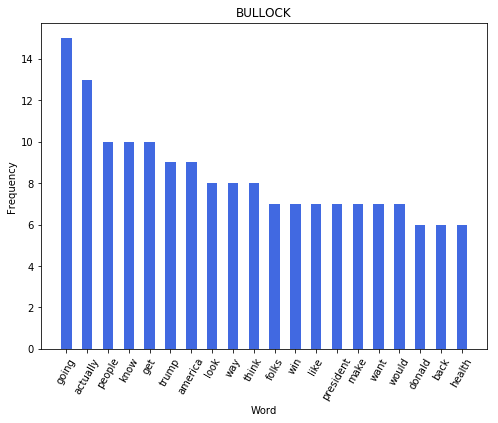

BULLOCK : 439 : {'us', 'back', 'get', 'like', 'lines', 'folks', 'win', 'shows', 'end', 'surprise', 'fuel', 'able', 'make', 'transition', 'voices', 'apart', 'easy', 'problems', 'scientists', 'care', 'used', 'farmers', 'playground', 'washington', 'longer', 'executive', 'start', 'build', 'focus', 'blocks', 'citizens', 'border', 'president', 'democrat', 'hands', 'career', 'labor', 'drawing', 'challenge', 'buy', 'fought', 'many', 'weapon', 'list', 'voters', 'choice', 'talked', 'tweets', 'give', 'donald', 'know', 'clean', 'coal', 'adversaries', 'said', 'go', 'neutral', 'miner', 'term', 'koch', 'nothing', 'fight', 'paycheck', 'would', 'path', 'recognize', 'governor', 'days', 'influence', 'right', 'lot', 'sure', 'expectancy', 'exists', 'city', 'blunt', 'allies', 'shower', 'world', 'criminal', 'leader', 'thanks', 'others', 'starts', 'climate', 'prescription', 'sacrifice', 'playing', 'kicking', 'decades', 'return', 'stopped', 'competing', 'corporations', 'repeal', 'country', 'workers', 'concerne

In [35]:
find_plot_frequencies(grouped_df3, candidate_list2_1)


In [33]:
Dfinal_score = []


for first_name in candidate_list3:   
  synset_list1 = []
  for second_name in candidate_list3:
    synset_list2 = []
    for line1 in grouped_df5.get_group(first_name)['line']:
        synsets_temp = get_synsets(line1) 
        synset_list1.append(synsets_temp)
        synset_list1 = deep_flatten(synset_list1)

    for line2 in grouped_df5.get_group(second_name)['line']:
        synsets_temp2 = get_synsets(line2)
        synset_list2.append(synsets_temp2)
        synset_list2 = deep_flatten(synset_list2)
    
    fin_score = (similarity_score(synset_list1, synset_list2) + similarity_score(synset_list2, synset_list1)) / 2

    final_score.append((first_name, second_name, fin_score))
    print(final_score) 


KeyboardInterrupt: ignored

In [0]:
[('O ROURKE', 'SANDERS', 0.799812052941441), ('O ROURKE', 'WARREN', 0.8134399508057162), ('O ROURKE', 'BUTTIGIEG', 0.8196127875938466), ('O ROURKE', 'O ROURKE', 1.0), ('O ROURKE', 'KLOBUCHAR', 0.7971634328840274), ('O ROURKE', 'HICKENLOOPER', 0.7976552860403885), ('O ROURKE', 'RYAN', 0.7745576488404092), ('O ROURKE', 'DELANEY', 0.7987083029657586), ('O ROURKE', 'WILLIAMSON', 0.7704703367308956)

'O ROURKE'

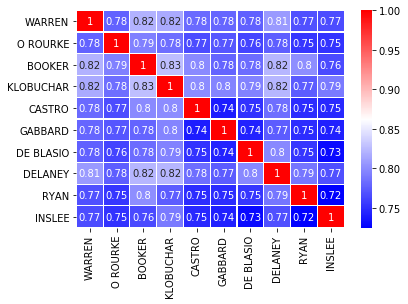

In [0]:
### Create Heatmap

'''Accent, CMRmap, GnBu_r, *Pastel1, *PuBu, Purples, Set2_r, Set3, *Spectral_r, 
*YlGnBu, **YlGnBu_r (c=.875), bwr, cividis, coolwarm, gist_earth, gist_stern, icefire, tab20b_r, '''


fin_sim1_1 = [('WARREN', 'WARREN', 1.0), ('WARREN', 'O ROURKE', 0.7775889921565746), ('WARREN', 'BOOKER', 0.8206309573756423), ('WARREN', 'KLOBUCHAR', 0.8167433314048291), ('WARREN', 'CASTRO', 0.7822241933259227), ('WARREN', 'GABBARD', 0.7803009860627175), ('WARREN', 'DE BLASIO', 0.7770055304056669), ('WARREN', 'DELANEY', 0.8081344583346364), ('WARREN', 'RYAN', 0.7683525101238243), ('WARREN', 'INSLEE', 0.7662305391182398), 
              ('O ROURKE', 'WARREN', 0.7775889921565756), ('O ROURKE', 'O ROURKE', 1.0), ('O ROURKE', 'BOOKER', 0.7935087465947632), ('O ROURKE', 'KLOBUCHAR', 0.7842901288355757), ('O ROURKE', 'CASTRO', 0.7657430748029965), ('O ROURKE', 'GABBARD', 0.7713480765781845), ('O ROURKE', 'DE BLASIO', 0.7614215868696852), ('O ROURKE', 'DELANEY', 0.7759711708755861), ('O ROURKE', 'RYAN', 0.7544082960284921), ('O ROURKE', 'INSLEE', 0.7520163805575233), 
              ('BOOKER', 'WARREN', 0.8206309573756426), ('BOOKER', 'O ROURKE', 0.793508746594763), ('BOOKER', 'BOOKER', 1.0), ('BOOKER', 'KLOBUCHAR', 0.8277658892330708), ('BOOKER', 'CASTRO', 0.7991113627615021), ('BOOKER', 'GABBARD', 0.778913649516974), ('BOOKER', 'DE BLASIO', 0.7827627402705215), ('BOOKER', 'DELANEY', 0.8231334734709344), ('BOOKER', 'RYAN', 0.801022602954221), ('BOOKER', 'INSLEE', 0.7649879264621713), 
              ('KLOBUCHAR', 'WARREN', 0.8167433314048289), ('KLOBUCHAR', 'O ROURKE', 0.7842901288355755), ('KLOBUCHAR', 'BOOKER', 0.8277658892330719), ('KLOBUCHAR', 'KLOBUCHAR', 1.0), ('KLOBUCHAR', 'CASTRO', 0.8000256386691313), ('KLOBUCHAR', 'GABBARD', 0.7965268882273077), ('KLOBUCHAR', 'DE BLASIO', 0.7947037933234563), ('KLOBUCHAR', 'DELANEY', 0.8235103837556068), ('KLOBUCHAR', 'RYAN', 0.7746370435580577), ('KLOBUCHAR', 'INSLEE', 0.7902476791365609), 
              ('CASTRO', 'WARREN', 0.7822241933259219), ('CASTRO', 'O ROURKE', 0.7657430748029971), ('CASTRO', 'BOOKER', 0.7991113627615062), ('CASTRO', 'KLOBUCHAR', 0.8000256386691311), ('CASTRO', 'CASTRO', 1.0), ('CASTRO', 'GABBARD', 0.7396868391265687), ('CASTRO', 'DE BLASIO', 0.7518604346337785), ('CASTRO', 'DELANEY', 0.7839313104589041), ('CASTRO', 'RYAN', 0.7484154894816188), ('CASTRO', 'INSLEE', 0.7467910978791885), 
              ('GABBARD', 'WARREN', 0.7803009860627197), ('GABBARD', 'O ROURKE', 0.7713480765781898), ('GABBARD', 'BOOKER', 0.7789136495169807), ('GABBARD', 'KLOBUCHAR', 0.7965268882273093), ('GABBARD', 'CASTRO', 0.7396868391265686), ('GABBARD', 'GABBARD', 1.0), ('GABBARD', 'DE BLASIO', 0.7437434071937621), ('GABBARD', 'DELANEY', 0.7743748714433057), ('GABBARD', 'RYAN', 0.7492913879226875), ('GABBARD', 'INSLEE', 0.7427685468126592), 
              ('DE BLASIO', 'WARREN', 0.7770055304056707), ('DE BLASIO', 'O ROURKE', 0.7614215868696899), ('DE BLASIO', 'BOOKER', 0.7827627402705274), ('DE BLASIO', 'KLOBUCHAR', 0.7947037933234596), ('DE BLASIO', 'CASTRO', 0.7518604346337809), ('DE BLASIO', 'GABBARD', 0.7437434071937633), ('DE BLASIO', 'DE BLASIO', 1.0), ('DE BLASIO', 'DELANEY', 0.7981448851601907), ('DE BLASIO', 'RYAN', 0.7537242225794752), ('DE BLASIO', 'INSLEE', 0.7307601582609626), 
              ('DELANEY', 'WARREN', 0.8081344583346419), ('DELANEY', 'O ROURKE', 0.7759711708755941), ('DELANEY', 'BOOKER', 0.823133473470939), ('DELANEY', 'KLOBUCHAR', 0.823510383755612), ('DELANEY', 'CASTRO', 0.7839313104589086), ('DELANEY', 'GABBARD', 0.7743748714433083), ('DELANEY', 'DE BLASIO', 0.7981448851601896), ('DELANEY', 'DELANEY', 1.0), ('DELANEY', 'RYAN', 0.7886528210164252), ('DELANEY', 'INSLEE', 0.7683543295191977), 
              ('RYAN', 'WARREN', 0.768352510123831), ('RYAN', 'O ROURKE', 0.7544082960285006), ('RYAN', 'BOOKER', 0.8010226029542228), ('RYAN', 'KLOBUCHAR', 0.7746370435580641), ('RYAN', 'CASTRO', 0.7484154894816233), ('RYAN', 'GABBARD', 0.74929138792269), ('RYAN', 'DE BLASIO', 0.7537242225794765), ('RYAN', 'DELANEY', 0.7886528210164273), ('RYAN', 'RYAN', 1.0), ('RYAN', 'INSLEE', 0.7246087844320057), 
              ('INSLEE', 'WARREN', 0.7662305391182471), ('INSLEE', 'O ROURKE', 0.7520163805575351), ('INSLEE', 'BOOKER', 0.764987926462174), ('INSLEE', 'KLOBUCHAR', 0.7902476791365686), ('INSLEE', 'CASTRO', 0.7467910978791952), ('INSLEE', 'GABBARD', 0.7427685468126639), ('INSLEE', 'DE BLASIO', 0.730760158260965), ('INSLEE', 'DELANEY', 0.7683543295192039), ('INSLEE', 'RYAN', 0.7246087844320094), ('INSLEE', 'INSLEE', 1.0)]


siml_list1_1 = [value[2] for value in fin_sim1_1]
siml_array1_1 = np.array(siml_list1_1)
siml_array1_1 = np.reshape(siml_array1_1, (10,10))
heatmap1_1 = sns.heatmap(siml_array1_1, annot=True, cmap='bwr', linewidths=.1, linecolor='white', xticklabels=[name for name in candidate_list1_1], yticklabels=[name for name in candidate_list1_1])


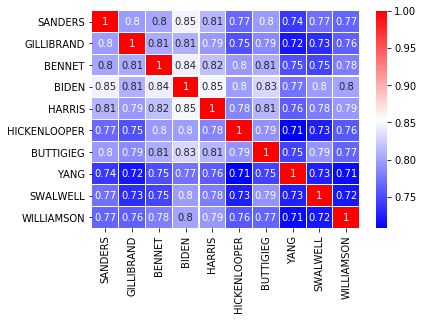

In [0]:
fin_sim1_2 = [('SANDERS', 'SANDERS', 1.0), ('SANDERS', 'GILLIBRAND', 0.797885179812974), ('SANDERS', 'BENNET', 0.803366035611897), ('SANDERS', 'BIDEN', 0.8459993993414161), ('SANDERS', 'HARRIS', 0.8111532022404843), ('SANDERS', 'HICKENLOOPER', 0.7675140056223819), ('SANDERS', 'BUTTIGIEG', 0.7956635309714232), ('SANDERS', 'YANG', 0.7407762080062096), ('SANDERS', 'SWALWELL', 0.7717204563218136), ('SANDERS', 'WILLIAMSON', 0.7656778545498211), 
               ('GILLIBRAND', 'SANDERS', 0.7978851798129754), ('GILLIBRAND', 'GILLIBRAND', 1.0), ('GILLIBRAND', 'BENNET', 0.8055457729091163), ('GILLIBRAND', 'BIDEN', 0.8084607367259096), ('GILLIBRAND', 'HARRIS', 0.794693273410646), ('GILLIBRAND', 'HICKENLOOPER', 0.7540403670480147), ('GILLIBRAND', 'BUTTIGIEG', 0.7873310837031258), ('GILLIBRAND', 'YANG', 0.7208008745212069), ('GILLIBRAND', 'SWALWELL', 0.7331471967325804), ('GILLIBRAND', 'WILLIAMSON', 0.76293627271749), 
               ('BENNET', 'SANDERS', 0.8033660356118979), ('BENNET', 'GILLIBRAND', 0.8055457729091164), ('BENNET', 'BENNET', 1.0), ('BENNET', 'BIDEN', 0.8439218830848577), ('BENNET', 'HARRIS', 0.8173408978669263), ('BENNET', 'HICKENLOOPER', 0.7954382538357461), ('BENNET', 'BUTTIGIEG', 0.8080111843394053), ('BENNET', 'YANG', 0.7531232778383217), ('BENNET', 'SWALWELL', 0.7476577697261448), ('BENNET', 'WILLIAMSON', 0.7807638994572331),
               ('BIDEN', 'SANDERS', 0.8459993993414162), ('BIDEN', 'GILLIBRAND', 0.8084607367259081), ('BIDEN', 'BENNET', 0.8439218830848565), ('BIDEN', 'BIDEN', 1.0), ('BIDEN', 'HARRIS', 0.8481619607042383), ('BIDEN', 'HICKENLOOPER', 0.798257398506323), ('BIDEN', 'BUTTIGIEG', 0.8299084047481459), ('BIDEN', 'YANG', 0.7731212831507855), ('BIDEN', 'SWALWELL', 0.7969165317867459), ('BIDEN', 'WILLIAMSON', 0.8021131904676247), 
               ('HARRIS', 'SANDERS', 0.8111532022404851), ('HARRIS', 'GILLIBRAND', 0.7946932734106453), ('HARRIS', 'BENNET', 0.8173408978669252), ('HARRIS', 'BIDEN', 0.8481619607042424), ('HARRIS', 'HARRIS', 1.0), ('HARRIS', 'HICKENLOOPER', 0.7833027555552019), ('HARRIS', 'BUTTIGIEG', 0.812190726158061), ('HARRIS', 'YANG', 0.7605631042096694), ('HARRIS', 'SWALWELL', 0.7792302606086146), ('HARRIS', 'WILLIAMSON', 0.79475712919845), 
               ('HICKENLOOPER', 'SANDERS', 0.7675140056223847), ('HICKENLOOPER', 'GILLIBRAND', 0.7540403670480146), ('HICKENLOOPER', 'BENNET', 0.7954382538357456), ('HICKENLOOPER', 'BIDEN', 0.7982573985063286), ('HICKENLOOPER', 'HARRIS', 0.7833027555552077), ('HICKENLOOPER', 'HICKENLOOPER', 1.0), ('HICKENLOOPER', 'BUTTIGIEG', 0.7919690268308702), ('HICKENLOOPER', 'YANG', 0.7077187738682902), ('HICKENLOOPER', 'SWALWELL', 0.7255395196653708), ('HICKENLOOPER', 'WILLIAMSON', 0.7581277845275426), 
               ('BUTTIGIEG', 'SANDERS', 0.7956635309714283), ('BUTTIGIEG', 'GILLIBRAND', 0.7873310837031275), ('BUTTIGIEG', 'BENNET', 0.8080111843394071), ('BUTTIGIEG', 'BIDEN', 0.8299084047481489), ('BUTTIGIEG', 'HARRIS', 0.8121907261580641), ('BUTTIGIEG', 'HICKENLOOPER', 0.7919690268308651), ('BUTTIGIEG', 'BUTTIGIEG', 1.0), ('BUTTIGIEG', 'YANG', 0.7454532299373426), ('BUTTIGIEG', 'SWALWELL', 0.7926761320899717), ('BUTTIGIEG', 'WILLIAMSON', 0.7657919799815813), 
               ('YANG', 'SANDERS', 0.7407762080062145), ('YANG', 'GILLIBRAND', 0.7208008745212091), ('YANG', 'BENNET', 0.7531232778383254), ('YANG', 'BIDEN', 0.7731212831507939), ('YANG', 'HARRIS', 0.7605631042096783), ('YANG', 'HICKENLOOPER', 0.7077187738682874), ('YANG', 'BUTTIGIEG', 0.74545322993735), ('YANG', 'YANG', 1.0), ('YANG', 'SWALWELL', 0.7260495044883235), ('YANG', 'WILLIAMSON', 0.7143805345236576), 
               ('SWALWELL', 'SANDERS', 0.771720456321819), ('SWALWELL', 'GILLIBRAND', 0.7331471967325848), ('SWALWELL', 'BENNET', 0.7476577697261491), ('SWALWELL', 'BIDEN', 0.7969165317867453), ('SWALWELL', 'HARRIS', 0.7792302606086203), ('SWALWELL', 'HICKENLOOPER', 0.7255395196653698), ('SWALWELL', 'BUTTIGIEG', 0.7926761320899788), ('SWALWELL', 'YANG', 0.7260495044883242), ('SWALWELL', 'SWALWELL', 1.0), ('SWALWELL', 'WILLIAMSON', 0.7211850597196824), 
               ('WILLIAMSON', 'SANDERS', 0.7656778545498317), ('WILLIAMSON', 'GILLIBRAND', 0.762936272717497), ('WILLIAMSON', 'BENNET', 0.780763899457241), ('WILLIAMSON', 'BIDEN', 0.8021131904676213), ('WILLIAMSON', 'HARRIS', 0.7947571291984503), ('WILLIAMSON', 'HICKENLOOPER', 0.7581277845275423), ('WILLIAMSON', 'BUTTIGIEG', 0.7657919799815904), ('WILLIAMSON', 'YANG', 0.714380534523658), ('WILLIAMSON', 'SWALWELL', 0.7211850597196835), ('WILLIAMSON', 'WILLIAMSON', 1.0)]


siml_list1_2 = [value[2] for value in fin_sim1_2]
siml_array1_2 = np.array(siml_list1_2)
siml_array1_2 = np.reshape(siml_array1_2, (10,10))
heatmap1_2 = sns.heatmap(siml_array1_2, annot=True, cmap='bwr', linewidths=.1, linecolor='white', xticklabels=[name for name in candidate_list1_2], yticklabels=[name for name in candidate_list1_2])


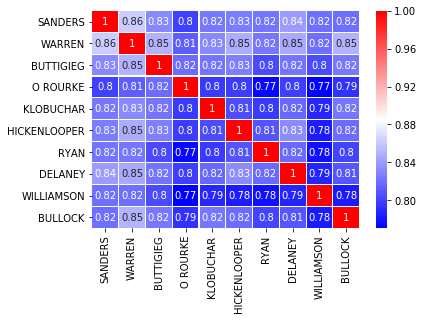

In [20]:
fin_sim2_1 =   [('SANDERS', 'SANDERS', 1.0), ('SANDERS', 'WARREN', 0.862250456756505), ('SANDERS', 'BUTTIGIEG', 0.8314628618063289), ('SANDERS', 'O ROURKE', 0.799812052941441), ('SANDERS', 'KLOBUCHAR', 0.8249745848760791), ('SANDERS', 'HICKENLOOPER', 0.8266156242372797), ('SANDERS', 'RYAN', 0.822672275270477), ('SANDERS', 'DELANEY', 0.8409118701651713), ('SANDERS', 'WILLIAMSON', 0.8211310311117359), ('SANDERS', 'BULLOCK', 0.8203005542291184), 
                 ('WARREN', 'SANDERS', 0.8622504567565048), ('WARREN', 'WARREN', 1.0), ('WARREN', 'BUTTIGIEG', 0.8508545092164859), ('WARREN', 'O ROURKE', 0.8134399508057162), ('WARREN', 'KLOBUCHAR', 0.8318457081214313), ('WARREN', 'HICKENLOOPER', 0.8478127597683552), ('WARREN', 'RYAN', 0.8235318210601832), ('WARREN', 'DELANEY', 0.846114253311401), ('WARREN', 'WILLIAMSON', 0.8205716308928507), ('WARREN', 'BULLOCK', 0.8509308729851766), 
                 ('BUTTIGIEG', 'SANDERS', 0.8314628618063282), ('BUTTIGIEG', 'WARREN', 0.8508545092164862), ('BUTTIGIEG', 'BUTTIGIEG', 1.0), ('BUTTIGIEG', 'O ROURKE',  0.8196127875938466), ('BUTTIGIEG', 'KLOBUCHAR', 0.8226818147651145), ('BUTTIGIEG', 'HICKENLOOPER', 0.8275342389905349), ('BUTTIGIEG', 'RYAN', 0.8043241405475388), ('BUTTIGIEG', 'DELANEY', 0.8230403332842269), ('BUTTIGIEG', 'WILLIAMSON', 0.8040916556244293), ('BUTTIGIEG', 'BULLOCK', 0.8248116469310243),
                 ('O ROURKE', 'SANDERS', 0.799812052941441), ('O ROURKE', 'WARREN', 0.8134399508057162), ('O ROURKE', 'BUTTIGIEG', 0.8196127875938466), ('O ROURKE', 'O ROURKE', 1.0), ('O ROURKE', 'KLOBUCHAR', 0.7971634328840274), ('O ROURKE', 'HICKENLOOPER', 0.7976552860403885), ('O ROURKE', 'RYAN', 0.7745576488404092), ('O ROURKE', 'DELANEY', 0.7987083029657586), ('O ROURKE', 'WILLIAMSON', 0.7704703367308956), ('O ROURKE', 'BULLOCK', 0.7930909409765949),
                 ('KLOBUCHAR', 'SANDERS', 0.8249745848760845), ('KLOBUCHAR', 'WARREN', 0.8318457081214361), ('KLOBUCHAR', 'BUTTIGIEG', 0.8226818147651191), ('KLOBUCHAR', 'O ROURKE', 0.7971634328840274), ('KLOBUCHAR', 'KLOBUCHAR', 1.0), ('KLOBUCHAR', 'HICKENLOOPER', 0.8052428744344031), ('KLOBUCHAR', 'RYAN', 0.7966204102370726), ('KLOBUCHAR', 'DELANEY', 0.8174575030427151), ('KLOBUCHAR', 'WILLIAMSON', 0.7876790182204431), ('KLOBUCHAR', 'BULLOCK', 0.8238512646309053),
                 ('HICKENLOOPER', 'SANDERS', 0.8266156242372866), ('HICKENLOOPER', 'WARREN', 0.8478127597683571), ('HICKENLOOPER', 'BUTTIGIEG', 0.827534238990542), ('HICKENLOOPER', 'O ROURKE', 0.7976552860403885), ('HICKENLOOPER', 'KLOBUCHAR', 0.8052428744344078), ('HICKENLOOPER', 'HICKENLOOPER', 1.0), ('HICKENLOOPER', 'RYAN', 0.8089547791882672), ('HICKENLOOPER', 'DELANEY', 0.8338585170613033), ('HICKENLOOPER', 'WILLIAMSON', 0.7831503475662153), ('HICKENLOOPER', 'BULLOCK', 0.8195526033659803), 
                 ('RYAN', 'SANDERS', 0.8226722752704784), ('RYAN', 'WARREN', 0.8235318210601821), ('RYAN', 'BUTTIGIEG', 0.8043241405475424), ('RYAN', 'O ROURKE', 0.7745576488404092), ('RYAN', 'KLOBUCHAR', 0.7966204102370762), ('RYAN', 'HICKENLOOPER', 0.8089547791882669), ('RYAN', 'RYAN', 1.0), ('RYAN', 'DELANEY', 0.8180277014649167), ('RYAN', 'WILLIAMSON', 0.7776789029389422), ('RYAN', 'BULLOCK', 0.8016383430175658),
                 ('DELANEY', 'SANDERS', 0.8409118701651681), ('DELANEY', 'WARREN', 0.8461142533113952), ('DELANEY', 'BUTTIGIEG', 0.8230403332842271), ('DELANEY', 'O ROURKE', 0.7987083029657586), ('DELANEY', 'KLOBUCHAR', 0.8174575030427189), ('DELANEY', 'HICKENLOOPER', 0.8338585170613049), ('DELANEY', 'RYAN', 0.8180277014649178), ('DELANEY', 'DELANEY', 1.0), ('DELANEY', 'WILLIAMSON', 0.7866811639650422), ('DELANEY', 'BULLOCK', 0.8098380412896546),
                 ('WILLIAMSON', 'SANDERS', 0.8211310311117315), ('WILLIAMSON', 'WARREN', 0.8205716308928426), ('WILLIAMSON', 'BUTTIGIEG', 0.804091655624426), ('WILLIAMSON', 'O ROURKE',  0.7704703367308956), ('WILLIAMSON', 'KLOBUCHAR', 0.7876790182204525), ('WILLIAMSON', 'HICKENLOOPER', 0.7831503475662203), ('WILLIAMSON', 'RYAN', 0.7776789029389477), ('WILLIAMSON', 'DELANEY', 0.7866811639650464), ('WILLIAMSON', 'WILLIAMSON', 1.0), ('WILLIAMSON', 'BULLOCK', 0.7825020057298477),
                ('BULLOCK', 'SANDERS', 0.82030055422911), ('BULLOCK', 'WARREN', 0.8509308729851668), ('BULLOCK', 'BUTTIGIEG', 0.8248116469310164), ('BULLOCK', 'O ROURKE', 0.7930909409765949), ('BULLOCK', 'KLOBUCHAR', 0.8238512646309037), ('BULLOCK', 'HICKENLOOPER', 0.8195526033659846), ('BULLOCK', 'RYAN', 0.8016383430175629), ('BULLOCK', 'DELANEY', 0.8098380412896478), ('BULLOCK', 'WILLIAMSON', 0.7825020057298471), ('BULLOCK', 'BULLOCK', 1.0)]
                
                 
siml_list2_1 = [value[2] for value in fin_sim2_1]
siml_array2_1 = np.array(siml_list2_1)
siml_array2_1 = siml_array2_1.reshape((10,10))
heatmap2_1 = sns.heatmap(siml_array2_1, annot=True, cmap='bwr', linewidths=.1, linecolor='white', xticklabels=[name for name in candidate_list2_1], yticklabels=[name for name in candidate_list2_1])


In [0]:
candidate_list2_1[4:]

['KLOBUCHAR', 'HICKENLOOPER', 'RYAN', 'DELANEY', 'WILLIAMSON', 'BULLOCK']

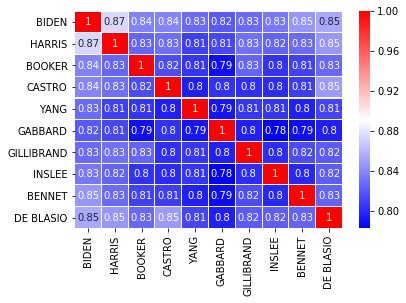

In [0]:
fin_sim2_2 = [('BIDEN', 'BIDEN', 1.0), ('BIDEN', 'HARRIS', 0.8748413603851557), ('BIDEN', 'BOOKER', 0.8384382273431201), ('BIDEN', 'CASTRO', 0.8391702572954836), ('BIDEN', 'YANG', 0.8284450838713096), ('BIDEN', 'GABBARD', 0.8208421796948889), ('BIDEN', 'GILLIBRAND', 0.8282842437402455), ('BIDEN', 'INSLEE', 0.8335315787450511), ('BIDEN', 'BENNET', 0.8470735265233176), ('BIDEN', 'DE BLASIO', 0.8543477103910035), 
               ('HARRIS', 'BIDEN', 0.8748413603851549), ('HARRIS', 'HARRIS', 1.0), ('HARRIS', 'BOOKER', 0.8253963361776289), ('HARRIS', 'CASTRO', 0.829704866832607), ('HARRIS', 'YANG', 0.80949413763224), ('HARRIS', 'GABBARD', 0.8125322120573466), ('HARRIS', 'GILLIBRAND', 0.8309666529711068), ('HARRIS', 'INSLEE', 0.8246947464112858), ('HARRIS', 'BENNET', 0.8282062899163208), ('HARRIS', 'DE BLASIO', 0.8466739456980252), 
               ('BOOKER', 'BIDEN', 0.8384382273431227), ('BOOKER', 'HARRIS', 0.82539633617763), ('BOOKER', 'BOOKER', 1.0), ('BOOKER', 'CASTRO', 0.8150911977571815), ('BOOKER', 'YANG', 0.8052880964083355), ('BOOKER', 'GABBARD', 0.789578432119177), ('BOOKER', 'GILLIBRAND', 0.8253794735749609), ('BOOKER', 'INSLEE', 0.8044427646997114), ('BOOKER', 'BENNET', 0.8103224771202622), ('BOOKER', 'DE BLASIO', 0.8271934539973684), 
               ('CASTRO', 'BIDEN', 0.83917025729549), ('CASTRO', 'HARRIS', 0.8297048668326105), ('CASTRO', 'BOOKER', 0.8150911977571829), ('CASTRO', 'CASTRO', 1.0), ('CASTRO', 'YANG', 0.7959219397373861), ('CASTRO', 'GABBARD', 0.8033167102857179), ('CASTRO', 'GILLIBRAND', 0.8027792168925425), ('CASTRO', 'INSLEE', 0.8014602266659325), ('CASTRO', 'BENNET', 0.8089385285447496), ('CASTRO', 'DE BLASIO', 0.8489283134192016), 
               ('YANG', 'BIDEN', 0.8284450838713094), ('YANG', 'HARRIS', 0.8094941376322455), ('YANG', 'BOOKER', 0.805288096408338), ('YANG', 'CASTRO', 0.795921939737386), ('YANG', 'YANG', 1.0), ('YANG', 'GABBARD', 0.7914600000246389), ('YANG', 'GILLIBRAND', 0.8062621095998466), ('YANG', 'INSLEE', 0.8051390872870877), ('YANG', 'BENNET', 0.7967091059200953), ('YANG', 'DE BLASIO', 0.8121107438438434), 
               ('GABBARD', 'BIDEN', 0.8208421796948815), ('GABBARD', 'HARRIS', 0.8125322120573442), ('GABBARD', 'BOOKER', 0.7895784321191817), ('GABBARD', 'CASTRO', 0.8033167102857213), ('GABBARD', 'YANG', 0.7914600000246408), ('GABBARD', 'GABBARD', 1.0), ('GABBARD', 'GILLIBRAND', 0.7964950541130875), ('GABBARD', 'INSLEE', 0.7828277800289455), ('GABBARD', 'BENNET', 0.7879902573262317), ('GABBARD', 'DE BLASIO', 0.7957423689347771), 
               ('GILLIBRAND', 'BIDEN', 0.8282842437402348), ('GILLIBRAND', 'HARRIS', 0.8309666529711008), ('GILLIBRAND', 'BOOKER', 0.8253794735749667), ('GILLIBRAND', 'CASTRO', 0.8027792168925464), ('GILLIBRAND', 'YANG', 0.8062621095998486), ('GILLIBRAND', 'GABBARD', 0.796495054113087), ('GILLIBRAND', 'GILLIBRAND', 1.0), ('GILLIBRAND', 'INSLEE', 0.8020966449214006), ('GILLIBRAND', 'BENNET', 0.8151517540736509), ('GILLIBRAND', 'DE BLASIO', 0.8214626639432501), 
               ('INSLEE', 'BIDEN', 0.8335315787450353), ('INSLEE', 'HARRIS', 0.8246947464112779), ('INSLEE', 'BOOKER', 0.8044427646997163), ('INSLEE', 'CASTRO', 0.8014602266659385), ('INSLEE', 'YANG', 0.8051390872870949), ('INSLEE', 'GABBARD', 0.7828277800289514), ('INSLEE', 'GILLIBRAND', 0.8020966449214052), ('INSLEE', 'INSLEE', 1.0), ('INSLEE', 'BENNET', 0.7991818392905186), ('INSLEE', 'DE BLASIO', 0.821966514005618), 
               ('BENNET', 'BIDEN', 0.8470735265233056), ('BENNET', 'HARRIS', 0.8282062899163093), ('BENNET', 'BOOKER', 0.8103224771202622), ('BENNET', 'CASTRO', 0.8089385285447555), ('BENNET', 'YANG', 0.7967091059201032), ('BENNET', 'GABBARD', 0.7879902573262384), ('BENNET', 'GILLIBRAND', 0.8151517540736497), ('BENNET', 'INSLEE', 0.7991818392905177), ('BENNET', 'BENNET', 1.0), ('BENNET', 'DE BLASIO', 0.8251274498111569), 
               ('DE BLASIO', 'BIDEN', 0.8543477103909949), ('DE BLASIO', 'HARRIS', 0.8466739456980119), ('DE BLASIO', 'BOOKER', 0.8271934539973647), ('DE BLASIO', 'CASTRO', 0.8489283134192052), ('DE BLASIO', 'YANG', 0.8121107438438454), ('DE BLASIO', 'GABBARD', 0.7957423689347769), ('DE BLASIO', 'GILLIBRAND', 0.8214626639432424), ('DE BLASIO', 'INSLEE', 0.8219665140056172), ('DE BLASIO', 'BENNET', 0.8251274498111576), ('DE BLASIO', 'DE BLASIO', 1.0)]

siml_list2_2 = [value[2] for value in fin_sim2_2]
siml_array2_2 = np.array(siml_list2_2)
siml_array2_2 = np.reshape(siml_array2_2, (10,10))
heatmap2_2 = sns.heatmap(siml_array2_2, annot=True, cmap='bwr', linewidths=.1, linecolor='white', xticklabels=[name for name in candidate_list2_2], yticklabels=[name for name in candidate_list2_2])
